# A tutorial for clustervisualiser.py

This notebook shows a small demonstration for `clustervisualizer.py`, one of the five types we can currently visualize. 
It visualizes the magin for two 2D-Clusters with the Support-Vector-Machine (SVM) and three different kernels `linear`, `rbf` and `sigmoid`.
We are creating an example cluster, plot several datapoints and then lay a heatmap over it. 
Overview:
1. Imports
2. A small demonstration
3. But what is SVM?
4. Code breakdown: What happens step by step?
5. All about flags
6. Further reading
NOTE: Please load imports and demo first so that the notebook works properly.

## 1. Imports:
At first, we need to import several packages. 

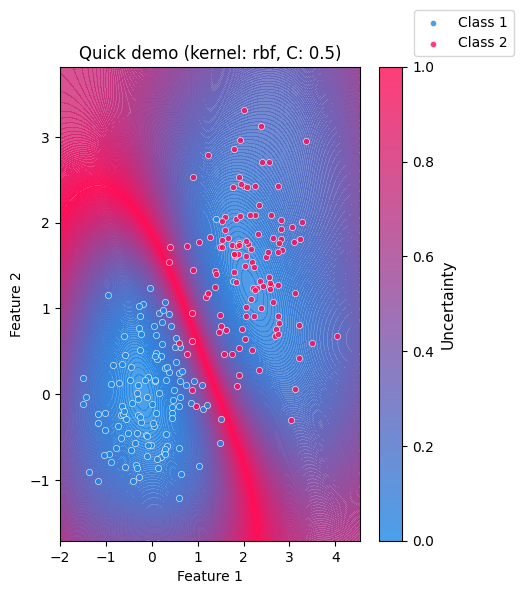

Imports successfully loaded.


In [1]:
import numpy as np

from probly.visualization.clustermargin.clustervisualizer import plot_uncertainty

print("Imports successfully loaded.")

## 2. A small demonstration:
We generate two reproducible 2D clusters using a fixed random seed, which is set to `value = 42` in this example for consistent results.
The cluster centers are controlled via `loc` and their spread and overlap via `scale`.

We then call `plot_uncertainty()` to visualize the samples and a heatmap derived from an SVM decision boundary.

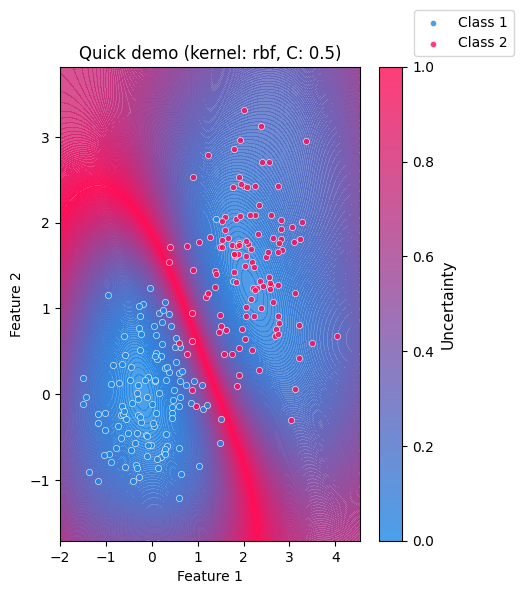

Demo loaded with seed 42.


In [2]:
value = 42
rng = np.random.default_rng(value)

n1, n2 = 120, 120
cluster1 = rng.normal(loc=(0.0, 0.0), scale=0.7, size=(n1, 2))
cluster2 = rng.normal(loc=(2.0, 1.5), scale=0.7, size=(n2, 2))

plot_uncertainty(
    cluster1,
    cluster2,
    title="Quick demo",
    kernel="rbf",
    C=0.5,
    gamma="scale",
    show=True,
)
print(f"Demo loaded with seed {value}.")

## 3. But what is SVM?

A Support Vector Machine (SVM) is a supervised classifier that separates classes by learning a **decision boundary**.
In the linear case, this boundary is a straight line (in 2D); with nonlinear kernels (e.g. RBF), it can become curved.

We use an SVM in this demo because it provides a natural notion of **distance to the boundary** via the *decision function*.
Points close to the boundary are typically harder to classify, so we treat small margins as **high uncertainty** and large margins as **low uncertainty**.
That distance-based signal is what we visualize as the margin heatmap.

## 4. Code breakdown: What happens step-by-step
### 4.1 Overview

This module visualizes margin between two 2D clusters using a Support Vector Machine (SVM).<br>
The plot consists of:
- the two labeled point clouds (scatter)
- a background heatmap showing margin between those two scatters

**Helper functions:**<br>

`_check_shape(input_data: np.ndarray) -> np.ndarray`:<br>
Purpose: Ensure input arrays have the expected format: a non-empty NumPy array with shape (n_samples, 2).

`_2_cluster_to_y(cluster1, cluster2) -> np.ndarray`:<br>
Purpose: Build the label vector y for SVM by validating both clusters with `_check_shape`

`_2_cluster_to_x(cluster1, cluster2) -> np.ndarray`:<br>
Purpose: Stack both clusters into a single feature matrix X ; validates both clusters and uses `np.vstack` to produce one array of shape (n1 + n2, 2)

`_plot_svm_beam(ax, clf, X, cmap) -> None`:<br>
Purpose: Compute and draw the margin heatmap based on the SVM.


**Main function:**<br>

`plot_uncertainty() -> plt.Axes`:<br>
Visualizes how *uncertain* a Support Vector Machine (SVM) is when separating two **2D clusters**.<br>
The output combines:
- **Scatter points** for both clusters (the raw data)
- A **background heatmap** that is brightest near the SVM decision boundary and fades away as points become easier to classify.<br>

*What it does:*
- Creation of axes (optional), makes the function usable both standalone and in multi-plot notebooks.
- Build training data `X` and labels `y`, then combined into clustes with their corresponding lables.
- Input an parameter validation before fitting: `X`, `gamma` and `C` are checked for right values and `len(X) == len(y)` checks if every sample has a label.
- `labels` and `title` are annotated with the given (or default) parameters.
- Each class is plotted with `ax.scatter()`. 
- Result is a decision function that can be evaluated anywhere in the 2D plane.
- Heatmap is computed with `_plot_svm_beam()` and drawn.
- If `show=True`, it calls `plt.show()` so that the plot is shown.

**How to read the result:**<br>
- Bright regions (high values) indicate **low margin**, points close to the decision boundary -> **high uncertainty**.
- Darker regions indicate **high margin**, points far from the boundary -> **low uncertainty**.
- Tuning `kernel`, `C`, and `gamma` changes the boundary shape and therefore the width/shape of the margin band.

### 4.2 Difference between kernels

A `kernel` defines the shape of the decision boundary by implicitly mapping the data into another feature space. <br>

**kernel="linear":** <br>
Decision boundary is a **straight line** in 2D (a hyperplane in higher dimensions).
Works best when classes are approximately linearly separable.<br>
**Pros:** fast, simple, stable, fewer hyperparameters. <br>
**Cons:** cannot model curved boundaries.<br>
In the plot: expect a mostly straight separating region and margin band.

**kernel="rbf" (Radial Basis Function):**<br>
Produces **nonlinear** boundaries.
Great default when you expect complex shapes or overlapping clusters.
Sensitive to `gamma` and `C`.<br>
In the plot: can create curved separation with an margin band that adapts to the data geometry.

**kernel="sigmoid":**<br>
Nonlinear kernel inspired by **neural networks**.
Can work, but is often less reliable than `rbf` unless tuned carefully.
Sensitive to scaling and `gamma`.<br>
In the plot: can look similar to linear in some settings, or behave oddly if parameters are not well tuned.

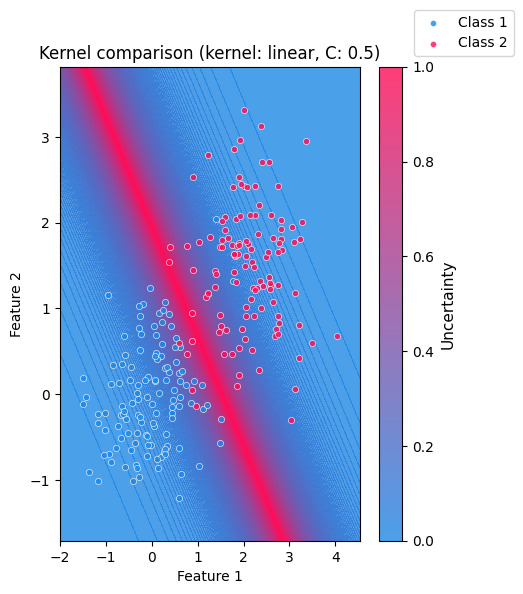

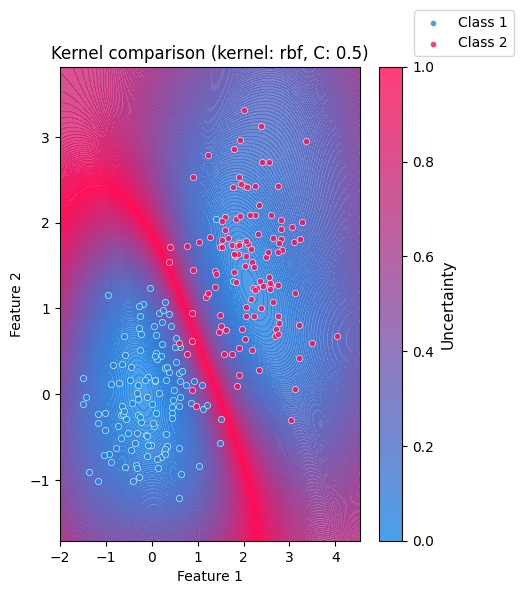

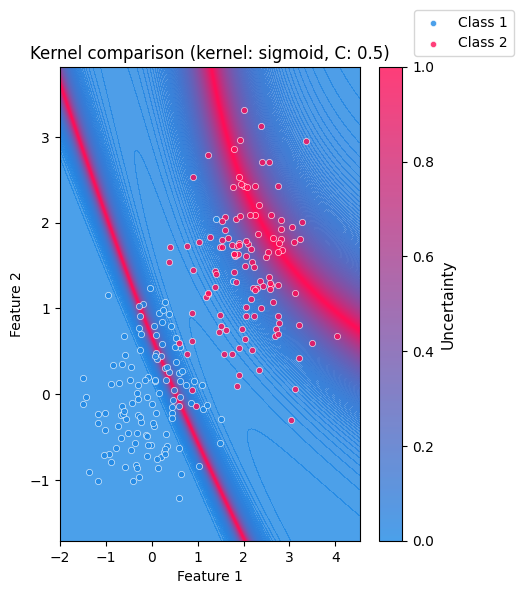

In [3]:
for kernel in ["linear", "rbf", "sigmoid"]:
    plot_uncertainty(
        cluster1,
        cluster2,
        title="Kernel comparison",
        kernel=kernel,
        C=0.5,
        gamma="scale",
        show=True,
    )

### 4.3 How C influences the outcome.
`C` controls the trade-off between fitting data and keeping the decision boundary smooth.

**High C:** <br>
The model penalizes misclassifications strongly, it tries hard to classify every training point correctly.<br>
Result: tighter boundary, less tolerance for outliers, **higher risk of overfitting**.

**Low C:** <br>
The model allows **more classification errors**, it prefers a simpler boundary. <br>
Result: smoother boundary, more tolerance for noise/outliers, often better generalization.

In the clustermargin plot, changing `C` often changes how “tight” the transition region between the two clusters looks.

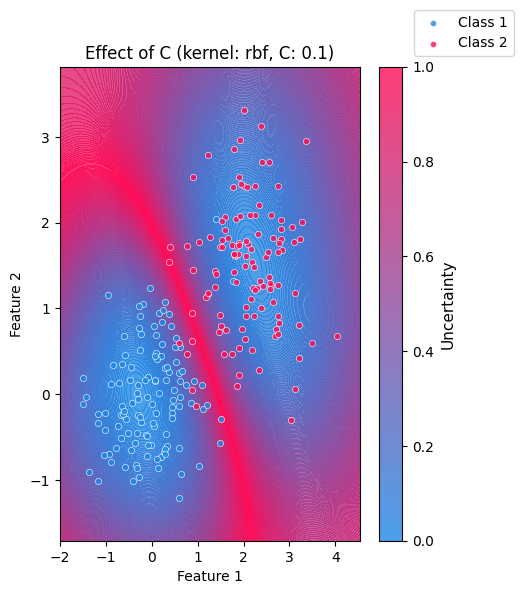

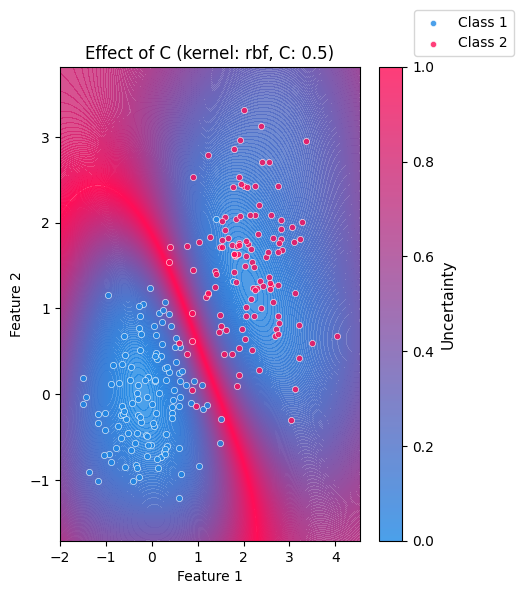

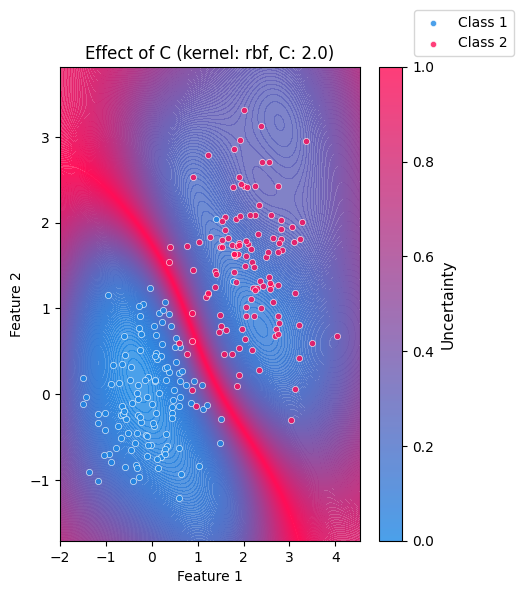

In [4]:
for C in [0.1, 0.5, 2.0]:
    plot_uncertainty(
        cluster1,
        cluster2,
        title="Effect of C",
        kernel="rbf",
        C=C,
        gamma="scale",
        show=True,
    )

### 4.4 How gamma influences the outcome.
`gamma` mostly matters for nonlinear kernels (`rbf` and `sigmoid`). It controls how far the influence of a single training point reaches.<br>

**High gamma:**<br>
Each point influences only a very **small neighborhood**.<br>
Result: the decision boundary becomes very local and wiggly, potentially overfitting.

**Low gamma:**<br>
Each point influences a **larger region**.<br>
Result: the boundary becomes smoother and more global, potentially underfitting.

**Special options:**<br>
`gamma="scale"`: uses 1 / (n_features * X.var())<br>
`gamma="auto"`: uses 1 / n_features

In `clustermargin`, `gamma` strongly affects how “narrow” or “wide” the uncertainty band is around the boundary.

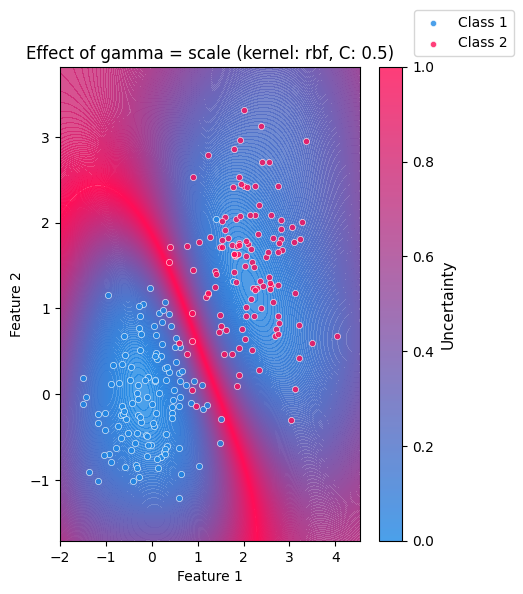

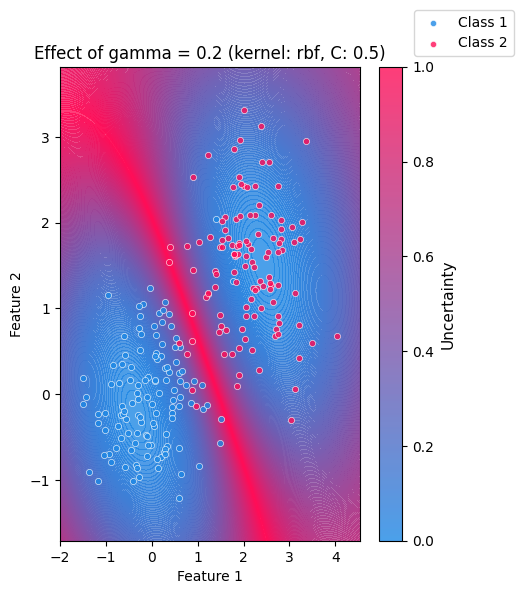

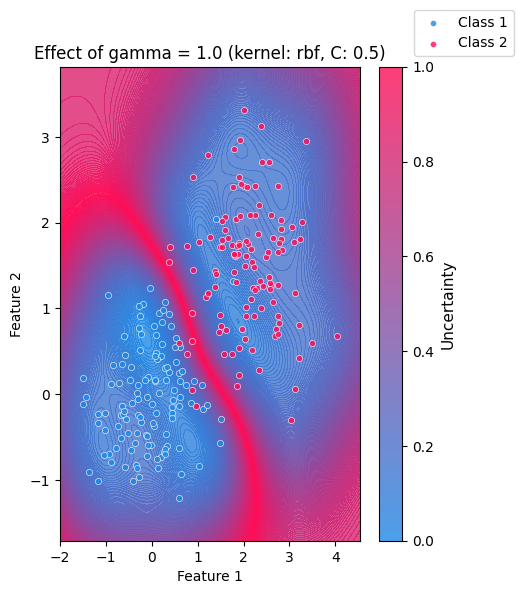

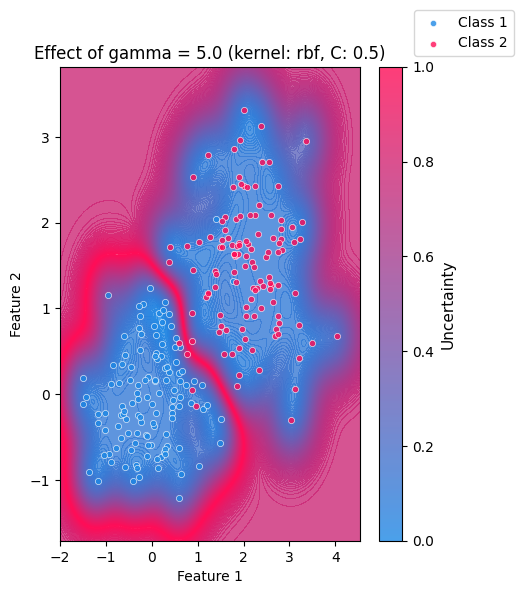

In [5]:
for gamma in ["scale", 0.2, 1.0, 5.0]:
    plot_uncertainty(
        cluster1,
        cluster2,
        title=f"Effect of gamma = {gamma}",
        kernel="rbf",
        C=0.5,
        gamma=gamma,
        show=True,
    )

### 5. All about flags:<br>
To use clustermargin the most flexible way, there are several flags you can use when calling `plot_uncertainty()`.<br>

`title`: Add a custom title for your plot. Defaults to *Uncertainty*.<br>
`x-label`: Add a custom name for the x-axis. Defaults to *Feature 1*.<br>
`y-label`: Add a custom name for the y-axis. Defaults to *Feature 2*.<br>
`class_labels`: List of names for classes. Defaults to to Class [i], where i is number of class.<br>
`kernel`: You can change the kernel as mentioned above. You can choose between `rbf` (default), `linear` and `sigmoid`.<br>
`C`: Regularization parameter, the lower, the more tolerant to outliers. Cannot be below 0.0. , defaults to 0.5.<br>
`gamma`: Kernel coefficient controlling the influence radius of samples. Higher values lead to more local decision boundaries. Can either be a float, `auto` or `scale` (default).<br>
`show`: Boolean, can either be `True` (dafault) or `False`.<br>

### 6. Further reading:
[Scikit SVM] https://scikit-learn.org/stable/modules/svm.html
